# Spam Detection with SMS Data

This project is on detecting spam short message services (SMS) in order to practice making machine learning models and to play around with text data. The data I will be looking at is from [Kaggle](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset).

The steps I will be taking for this project are:
- Looking at the data (what do we have?)
- Cleaning the data (removing any unnecessary words)
- Converting the text into numbers (Since computers only see 0 or 1)
- Training the models (4 models in total!)
- Evaluating the prediction of the models (to tell if a SMS is spam or not spam (called ham))

In [1]:
import helpers
import figures

## What does the data look like?

In [2]:
import pandas as pd

data = pd.read_csv("spam.csv",encoding='latin-1')
data.dtypes

v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

All the columns are *object* data types, that means we most likely have **text** (string) information in each of the columns.

To check if there are any null (empty) values in the columns:

In [3]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [4]:
data.count()

v1            5572
v2            5572
Unnamed: 2      50
Unnamed: 3      12
Unnamed: 4       6
dtype: int64

The columns *Unnamed: 2*, *Unnamed: 3*, and *Unnamed: 4* have a large number of null values (the proportion of null to non-null values are large)
The description of the dataset (from Kaggle) says that v1 is the classification and v2 is the SMS, so the other columns having a lot of null values makes sense. I wonder why it was included?

Since columns v1 and v2 are the columns that will work the best, we can rename v1 and v2 to **class** and **msg** to help with clarity.

In [5]:
data = data.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)

In [6]:
data = data.rename(columns={"v1":"class","v2":"msg"})
data

,class,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


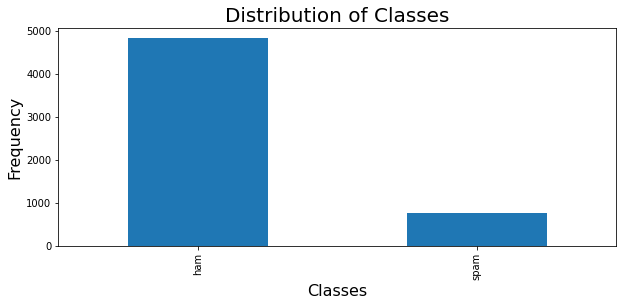

In [7]:
import matplotlib.pyplot as plt

figures.plot_dist_classes(data['class'].value_counts())

In [8]:
ham_size = data.groupby(['class']).size().ham
spam_size = data.groupby(['class']).size().spam
print("\nAmount of Ham: %d \nAmount of spam %d \n" %(ham_size, spam_size))


Amount of Ham: 4825 
Amount of spam 747 



Note that the ham class has a lot more entries than spam, which means that this is an imbalanced dataset.

Creating a word map of both spam and ham messages will help us visualise a difference between the two groups.

In [9]:
spam = data[data['class'] == 'spam']
ham = data[data['class'] == 'ham']

spam_words = helpers.get_words(spam.msg)
ham_words = helpers.get_words(ham.msg)

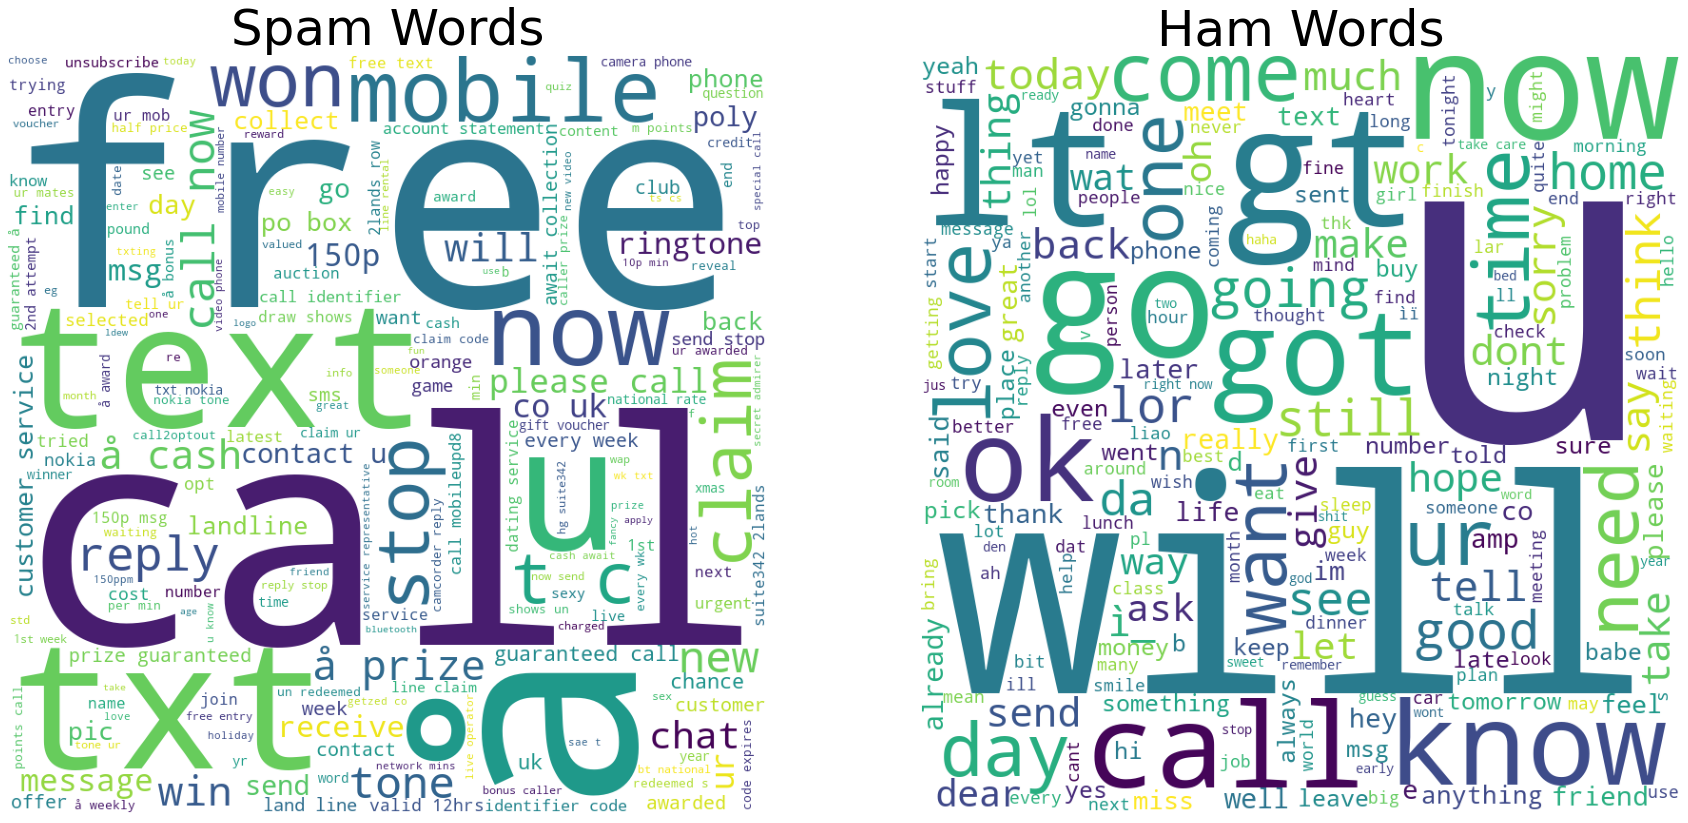

In [10]:
figures.plot_wordclouds(spam_words,ham_words)

Spam SMS has words like "txt, call, free, mobile, ..." and ham words are "will, u, now, go, ..."
There are words that both sets have in common ("u, now, call, ...") but hopefully there is a big enough difference between spam and ham messages that the models can tell the difference most of the time.

Let's start cleaning the data! The goal is to create the smallest set of unique words that will hopefully identify if the SMS is spam or not. Punctuation and whitespaces will be removed because whitespaces will not help us classify the SMS, and punctuation will be removed since "Hello!!!" is just "Hello" in meaning (although you could argue that punctuation could help classify the data but we want the smallest set possible). Stopping words, which are commonly used words that help make the sentance coherent but have no meaning in the English language (a, the, is, are), will be removed along with any numbers.

I will also try to get words to a root form by using stemming techniques such as PorterStemmer and WordNetLemmatizer. 

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/piercson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
from wordcloud import WordCloud, STOPWORDS
import re
def clean_text(col, technique):
    stopwords = STOPWORDS
    output = []
    if technique == 'PorterStemmer':
        tech = PorterStemmer()
        get_root = tech.stem
    else:
        tech = WordNetLemmatizer()
        get_root = tech.lemmatize
    
    tokens = col.split()
    for token in tokens:
        cleaned_token = token.lower()
        if token in stopwords:
            continue
        cleaned_token = re.sub(r'[0-9]+', '', cleaned_token)
        cleaned_token = re.sub(r'[^\w\s]', '', cleaned_token)
        cleaned_token = re.sub(r'[_]', '', cleaned_token)
        cleaned_token = get_root(cleaned_token)
        output.append(cleaned_token)
    output = list(filter(lambda x: x!='',output)) 
    return " ".join(word for word in output)

data['cleaned_stemm'] = data.msg.apply(clean_text,technique='PorterStemmer')
data['cleaned_lemm'] = data.msg.apply(clean_text,technique='WordNetLemmatizer')

print("\nCleaning Techniques!")
print("\nOriginal: %s" % data.head(1).msg.values)
print("PorterStemmer: %s" % data.head(1).cleaned_stemm.values)
print("Lemmatizer: %s" % data.head(1).cleaned_lemm.values)


Cleaning Techniques!

Original: ['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']
PorterStemmer: ['go jurong point crazi avail bugi n great world la e buffet cine got amor wat']
Lemmatizer: ['go jurong point crazy available bugis n great world la e buffet cine got amore wat']


## Creating the Models

For this dataset we have two classifications, **Spam** or **Ham**? 

The models I will be testing are:
From sklearn:
- Support Vector machine
- MultinomialNB
- Logistic regression

From TensorFlow:
- RNN (LSTM)

First I will gather the data into the features to be trained (X) and the corresponding classification (y). I will then split the data into training and validation sets (80% for training, and 20% for validation). The training set is what is used for the model to "learn" and the validation set is to check how the model does with data it has not seen. The training and validation sets should be disjoint (the sets should have no common SMS).

For the sklearn I will create a pipeline for all the models that will convert the words into numbers (CountVectorizer) and then it will weigh the words based on the SMS and all the words in the dataset (TfidfTransformer) and then use the classification method for each model.

In [13]:
from sklearn.model_selection import train_test_split

X = data.cleaned_stemm
y = data['class']
classifications = ["ham","spam"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.8, test_size=0.2,random_state=0)

###  Mutltinomial Naive Bayes
The first model I will use is The Mutltinomial Naive Bayes model.

The reason why I think this model could make a good prediction is because the Naive Baye's Models is based on the probabilities of the set of words given the classification.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import seaborn as sns

nb_pipe = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                  ])

model_nb = nb_pipe.fit(X_train, y_train)
y_pred = model_nb.predict(X_valid)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Multinomial Naive Bayes Accuracy %f \n' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=classifications))

Multinomial Naive Bayes Accuracy 0.954260 

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       949
        spam       1.00      0.69      0.82       166

    accuracy                           0.95      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.95      0.95      1115



The MultiNB model is ~95% accurate with the validation data but the overall accuracy does not tell whole story! With a classification report we can see what the precision and recall of the model is 

- The Precision column describes from the prediction of a given class, what is the accuracy of the prediction.
- The Recall column descibes for a given class, what is the overall accuracy of that class over all the predictions.

Personally I would rather if a ham SMS never be marked as spam but I would be okay with a few spam SMS making its way through the model.
The ham SMS predictions has a recall of 100% which means all the ham SMS was predicted correctly (yay!).

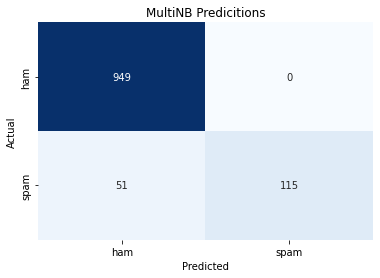

In [16]:
figures.plot_heatmap(y_valid,y_pred, classifications,"MultiNB Predicitions")

This is the heatmap of the predictions on the validation set. I think the heatmap gives a good visualization of the predictions since we only have 2 classes. 

### Support Vector Machine
A SVM tries to "draw" a line or curve to separate the classes. Depending on where which side of the line a data point lies is how the prediction is made. This is very easy to visualize in 2-Dimensions but our data is greater than 3-Dimensions which is super difficult to show.

In [17]:
from sklearn.linear_model import SGDClassifier 
svm_pipe = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('linear_svm', SGDClassifier(loss='hinge',penalty='l2', alpha=1e-5, random_state=0, max_iter=1000)),
                  ])
model_svm = svm_pipe.fit(X_train, y_train)
y_pred = model_svm.predict(X_valid)

In [18]:
print('Support Vector Machine Accuracy: %s' % accuracy_score(y_pred, y_valid))

Support Vector Machine Accuracy: 0.979372197309417


The SVM models has a accuracy of ~97.9% which is higher than the MultiNB but what about the precision and recall?

In [19]:
print(classification_report(y_valid, y_pred,target_names=classifications))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       949
        spam       0.97      0.89      0.93       166

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



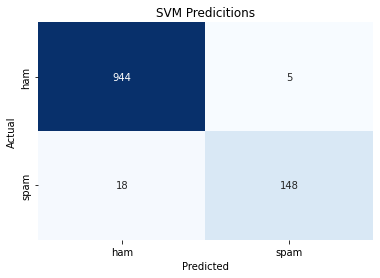

In [20]:
figures.plot_heatmap(y_valid,y_pred, classifications ,"SVM Predicitions")

The recall of the ham class went down to 99% meaning that there is a 99% chance that a ham SMS will be predicted correctly. Even though the overall accuracy went up, the recall of a ham SMS is not perfect. Let's see what SMS that were ham were marked as spam.

In [21]:
y_valid_ch = y_valid.reset_index()
not_ham_but_spam = []
for i, row in y_valid_ch.iterrows():
    if(row['class'] == "ham" and y_pred[i] == "spam"):
        not_ham_but_spam.append(X_valid.loc[row["index"]])
not_ham_but_spam

['i like new mobil',
 'sthi will increas chanc win',
 'cheer messag zogtoriu iåõv stare phone age decid whether text not',
 'god ask what forgiv a littl child gave love repli',
 'u messag']

We can see that the messages marked as spam has words like "new", "chance", "text, "message", "reply". These are words that would be in a spam SMS.

### Logistical Regression

In [22]:
from sklearn.linear_model import LogisticRegression
reg_pipe = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('regression', LogisticRegression()),
                  ])
model_reg = reg_pipe.fit(X_train, y_train)
y_pred = model_reg.predict(X_valid)

In [23]:
print('Logistic Regression Accuracy: %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=classifications))

Logistic Regression Accuracy: 0.9623318385650225
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       949
        spam       1.00      0.75      0.86       166

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.96      0.96      0.96      1115



The Logistic Regression model overall accuracy went down to ~96.2% compared to the SVM model but it is slightly better that the MultiNB model. We can see that the recall on ham SMS is 100% (yay!) and the other statistics are slightly better than the MultiNB model!

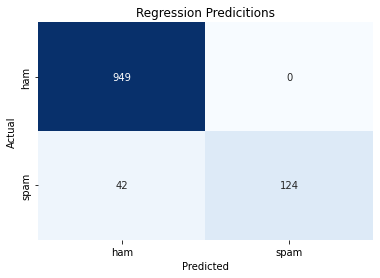

In [24]:
figures.plot_heatmap(y_valid,y_pred, classifications,"Regression Predicitions")

## Tensorflow

I will be testing the Long Short Term Memory (LSTM). I think this would be a good fit because the data is a sequence of words (a sentance) and I believe that there are words earlier that will relate to later words in the sequence when predicting if the SMS is spam. 

Setting up the data is similar to the sklearn models but we no longer have the nice pipeline.

In [25]:
#Get the occurances from the words
from collections import Counter

# Count the Unique words
def count_words(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

I first count the number of unique words in the cleaned set of words. This is used for the tokenizer to convert the features into sequences which will assign a number to each word in the feature set. We will also need to make sure that the sequneces put through the model are all the same length (pad with 0's). So let's look at a rough plot to see how the number of words of the cleaned SMS are distributed.

The mean is 10 and median is 8
Lowest value is 1 and the largest values is 89



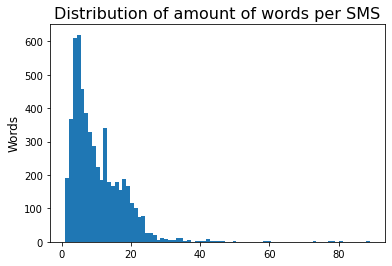

In [26]:
# Create Column for number or words in the SMS
data["num_words"] = data.cleaned_stemm.apply(lambda x: len(x.split(" ")))

figures.plot_num_words_per_sms(data["num_words"])

print("The mean is %d and median is %d" % (data["num_words"].mean(), data["num_words"].median()) )
print("Lowest value is %d and the largest values is %d\n" % (data["num_words"].min(), data["num_words"].max()) )

The distribution is right skewed. 

When choose a length for the sequence to be padded to, if we used the the largest number of words (89) as the sequence length then we would have a lot of useless information in most of the sequences. If we use the median we will truncate half of the SMS when converting them into the sequences so I think the best length for the sequence would be a length that includes 99% of the words (which is 33).

I will also convert the classifications to be either 0 or 1 (ham or spam respectively)

In [27]:
import numpy as np
import math 
# Features
X = data.cleaned_stemm
y = np.array(data['class'].apply(lambda x: classifications.index(x))) # Classifation (0-1)

words = count_words(X)
num_words = len(words)
max_words = math.floor(np.percentile(data["num_words"], 99))

print("Number of unique words is %d" % num_words)
print("Length of %d includes 99%% of the words" % max_words)

Number of unique words is 7232
Length of 33 includes 99% of the words


First create the tokenizer from the words in the cleaned SMS.

In [28]:
from keras.preprocessing.text import Tokenizer

# Create Index of words on dataset
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)

Separate into training and validation sets

In [29]:
# Partition Data
train_size = int(X.shape[0] * 0.8)
train_sentances = X[:train_size]
train_labels = y[:train_size]

valid_sentances = X[train_size:]
valid_labels = y[train_size:]

Confirm that we have about the same proportion of spam and ham words in each set. 

In [30]:
print("Training set contains %d spam words which is ~%d%% of the spam entries" % (train_labels.sum(), (train_labels.sum() / spam_size) * 100))
print("Validiation set contains %d spam words which is ~%d%% of the spam entries" % (valid_labels.sum(), (valid_labels.sum() / spam_size) * 100))

Training set contains 602 spam words which is ~80% of the spam entries
Validiation set contains 145 spam words which is ~19% of the spam entries


Then turn the features into sequences

In [31]:
# Turn to sequences from the tokenizer
Xtrain_sequences = tokenizer.texts_to_sequences(train_sentances)
Xvalid_sequences = tokenizer.texts_to_sequences(valid_sentances)

Then pad the sequence with 0's to make sure all sequences are equal length (length of 33)

*note:* 0 is not assigned to any word in the tokenizer and about 1% of the SMS will be truncated

In [32]:
from keras.preprocessing.sequence import pad_sequences

Xtrain_padded = pad_sequences(Xtrain_sequences, maxlen=max_words, padding="post", truncating="post")
Xvalid_padded = pad_sequences(Xvalid_sequences, maxlen=max_words, padding="post", truncating="post")

Now we can make the tensorflow model

- Embedding layer which takes in the input
- LSTM hidden layer
- Activation layer

In [33]:
from keras.models import Sequential
from tensorflow import keras
import tensorflow as tf

model_lstm = keras.Sequential()

model_lstm.add(keras.layers.Embedding(num_words,32,input_length=max_words))
model_lstm.add(keras.layers.LSTM(32, dropout=0.5))
model_lstm.add(keras.layers.Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.Adam()

model_lstm.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer, 
        metrics=["accuracy"])

In [34]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 32)            231424    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 239,777
Trainable params: 239,777
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model_lstm.fit(Xtrain_padded, train_labels, epochs=20, validation_data=(Xvalid_padded, valid_labels),)

Epoch 1/20
140/140 [==============================] - 3s 12ms/step - loss: 0.2961 - accuracy: 0.9028 - val_loss: 0.0809 - val_accuracy: 0.9848
Epoch 2/20
140/140 [==============================] - 1s 9ms/step - loss: 0.0586 - accuracy: 0.9863 - val_loss: 0.0531 - val_accuracy: 0.9830
Epoch 3/20
140/140 [==============================] - 1s 9ms/step - loss: 0.0299 - accuracy: 0.9944 - val_loss: 0.0464 - val_accuracy: 0.9848
Epoch 4/20
140/140 [==============================] - 1s 9ms/step - loss: 0.0255 - accuracy: 0.9951 - val_loss: 0.0457 - val_accuracy: 0.9821
Epoch 5/20
140/140 [==============================] - 1s 9ms/step - loss: 0.0137 - accuracy: 0.9971 - val_loss: 0.0509 - val_accuracy: 0.9812
Epoch 6/20
140/140 [==============================] - 1s 9ms/step - loss: 0.0124 - accuracy: 0.9969 - val_loss: 0.0455 - val_accuracy: 0.9830
Epoch 7/20
140/140 [==============================] - 1s 9ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0816 - val_accuracy: 0.9839
Epoch

In [36]:
results = model_lstm.evaluate(Xvalid_padded, valid_labels)
print("LSTM Accuracy is %s" % results[1])

35/35 [==============================] - 0s 2ms/step - loss: 0.1179 - accuracy: 0.9803
LSTM Accuracy is 0.9802690744400024


To get the classification report we need to do a bit of work to convert the predictions to the format that *classification_report* wants.

In [37]:
# Since we only have 2 classes, if the probability is greater than 50% then we mark it as spam (1)
classes_x=(model_lstm.predict(Xvalid_padded) > 0.5).astype("int32")
classes_x
prediction =  []
actual = []
for item in classes_x:
    prediction.append(classifications[item[0]])
for item in valid_labels:
    actual.append(classifications[item])
print(classification_report(actual, prediction,target_names=classifications))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       970
        spam       0.97      0.88      0.92       145

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Running this model will have slightly different outcomes because of the stochastic nature of the dropout in the LSTM layer but for the last time running this notebook, we have a overall accuracy of ~98%, and a recall of ham SMS is 100%

In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

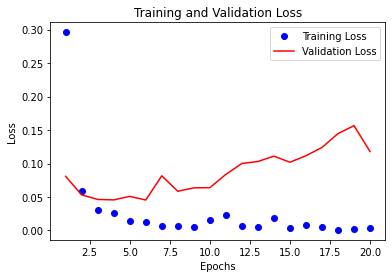

In [39]:
acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
figures.plot_loss(history_dict)

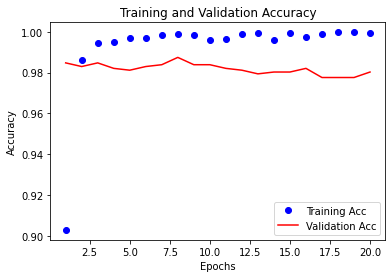

In [40]:
figures.plot_acc(history_dict)

Looking at the loss and accuracy plots, we can see that the model does do better on the training set compared to the validation set. I think the difference is okay and that the model is not overfitting because the difference between the training and validation is not that big.

## Conclusion

Overall I think I learned a lot on how to handle text data and feel a bit more comfortable with implementing models for prediction.

But before I end this notebook let's try some data that the models have not seen before!

In [41]:
very_much_spam = "Respond ASAP to clain a free alaska cruise for two people, text FREE to this number to claim your prize"
a_msg_from_my_mom = "Remember the noodle recipe you wrote when you were young? I framed it and i'm going to hang it in the kitchen. it looks so cute, i ll send a pic when it's up"
spam_clean = clean_text(very_much_spam, 'PorterStemmer')
mom_clean = clean_text(a_msg_from_my_mom, 'PorterStemmer')
# Spam
nm_spam_prediction = model_nb.predict([spam_clean])
svm_spam_prediction = model_svm.predict([spam_clean])
reg_spam_prediction = model_reg.predict([spam_clean])

spam_sequences = tokenizer.texts_to_sequences([spam_clean])
spam_padded = pad_sequences(spam_sequences, maxlen=max_words, padding="post", truncating="post")
lstm_spam_prediction=(model_lstm.predict(spam_padded) > 0.5).astype("int32")
print("For the SMS\n%s\n" % very_much_spam)
print("MultiNB predicts this is a %s SMS" % (nm_spam_prediction[0]))
print("SVM predicts this is a %s SMS" % (svm_spam_prediction[0]))
print("Regression predicts this is a %s SMS" % (reg_spam_prediction[0]))
print("LSTM predicts this is a %s SMS" % (classifications[lstm_spam_prediction[0][0]]))

# Mom Message
nm_mom_prediction = model_nb.predict([mom_clean])
svm_mom_prediction = model_svm.predict([mom_clean])
reg_mom_prediction = model_reg.predict([mom_clean])

mom_sequences = tokenizer.texts_to_sequences([mom_clean])
mom_padded = pad_sequences(mom_sequences, maxlen=max_words, padding="post", truncating="post")
lstm_mom_prediction=(model_lstm.predict(mom_padded) > 0.5).astype("int32")

print("\nFor the SMS\n%s\n" % a_msg_from_my_mom)
print("MultiNB predicts this is a %s SMS" % (nm_mom_prediction[0]))
print("SVM predicts this is a %s SMS" % (svm_mom_prediction[0]))
print("Regression predicts this is a %s SMS" % (reg_mom_prediction[0]))
print("LSTM predicts this is a %s SMS" % (classifications[lstm_mom_prediction[0][0]]))

For the SMS
Respond ASAP to clain a free alaska cruise for two people, text FREE to this number to claim your prize

MultiNB predicts this is a spam SMS
SVM predicts this is a spam SMS
Regression predicts this is a spam SMS
LSTM predicts this is a spam SMS

For the SMS
Remember the noodle recipe you wrote when you were young? I framed it and i'm going to hang it in the kitchen. it looks so cute, i ll send a pic when it's up

MultiNB predicts this is a ham SMS
SVM predicts this is a ham SMS
Regression predicts this is a ham SMS
LSTM predicts this is a ham SMS
